In [1]:
!pip install indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt

import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import pickle
from indicnlp.tokenize import indic_tokenize
import seaborn as sns

train_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/BBC/hi-train.csv'
test_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/BBC/hi-test.csv'
# val_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/BBC/hi/hi-valid.csv'
forward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_forward_model'
backward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_backward_model'
word_to_ix_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/word_to_ix.pkl'

In [7]:

train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])

test_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])
train_df.head()



,Label,Text
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])
test_df.head()


,Label,Text
0,3,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1,3,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2,3,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3,5,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4,3,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...


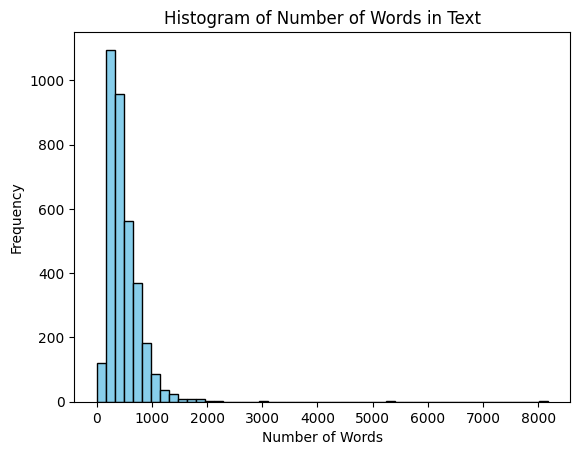

In [9]:

text_word_counts = train_df['Text'].apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


In [10]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)

        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wt_mat=torch.zeros(size=(90337,300))
embeddings=torch.tensor(wt_mat,dtype=torch.float)
forward_model= torch.load(forward_model_path,map_location=torch.device('cpu'))
backward_model= torch.load(backward_model_path,map_location=torch.device('cpu'))

<ipython-input-11-b61a903641ab>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [12]:
with open(word_to_ix_path, 'rb') as file:

    word_to_ix = pickle.load(file)


In [13]:
mxlen=[]
for column in train_df[train_df.columns[1]]:
    mxlen.append(len(column.split(' ')))
max(mxlen)

8175

In [14]:

mxlen = 30
class DatafetchClassify(Dataset):
    def __init__(self,split:str):
        sequence=[]
        labels=[]
        for x in tqdm(split[split.columns[1]],desc='Generate next word prediction data'):
            if len(x)<2 or x[0]=='=':continue
            words=indic_tokenize.trivial_tokenize(x,'hi') # alternative: x.strip().split(' ')
            words=words
            indices=[word_to_ix.get(word, 1) for word in words[:mxlen]]
            sequence.append((mxlen-len(indices))*[word_to_ix['<PAD>']]+indices[:])
        for x in tqdm(split[split.columns[0]],desc="Generate label"):
            labels.append(x)
        max_seq_len=max([len(ngram) for ngram in sequence])
        self.sequence=tensor(sequence)
        self.sequence.to(device)
        self.labels=tensor(labels)
        self.labels.to(device)
    def __len__(self)->int:
        return len(self.sequence)
    def __getitem__(self,index:int):
        return self.sequence[index],self.labels[index]

In [15]:
classifier_dataset=DatafetchClassify(train_df)

Generate label: 100%|██████████| 3467/3467 [00:00<00:00, 1258037.20it/s]


In [16]:
batch_size=64

In [17]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size,shuffle=True)
data,labels=next(iter(classifer_dataloader))


In [18]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,forward_model,backward_model,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.forward_model=forward_model
        self.embedding = forward_model.embedding
        self.backward_model=backward_model
        self.forward_model.requires_grad=False
        self.backward_model.requires_grad=False
        self.linear1=nn.Linear(100,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim*2,hidden_size=50,bidirectional=True,batch_first=True)
    def forward(self,embdata):
        _,o1f1,o2f2=self.forward_model(embdata)
        _,o1b1,o2b2=self.backward_model(embdata)
        # print(embdata.shape)
        # print('\n',o1f1.shape)
        embdata = self.embedding(embdata)
        e = torch.cat([embdata, embdata.flip(1)],dim=2)
        h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        h2=torch.cat([o2f2,o2b2.flip(1)],dim=2)
        bio,bih=self.bilstm(self.param0*e + self.param1*h1 +self.param2*h2)

        y=self.linear1(bio[:,-1,:])

        return y

In [22]:
classifier=ElmoClassifier(14,forward_model,backward_model,300)

In [23]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),1e-3)

In [24]:
for epoch in range(5):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()

        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train)
        loss=loss_fn(output.to(device),y_train.to(device))
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/55 [00:00<?, ?it/s]<ipython-input-10-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training: 100%|██████████| 55/55 [05:41<00:00,  6.21s/it]


90.39178097248077


Training: 100%|██████████| 55/55 [05:41<00:00,  6.21s/it]


62.40846186876297


Training: 100%|██████████| 55/55 [05:47<00:00,  6.32s/it]


51.057232707738876


Training: 100%|██████████| 55/55 [05:37<00:00,  6.14s/it]


42.09571287035942


Training: 100%|██████████| 55/55 [05:49<00:00,  6.35s/it]

33.054259061813354


In [25]:
classifier_eval=DatafetchClassify(test_df)

Generate label: 100%|██████████| 866/866 [00:00<00:00, 1038384.01it/s]


In [26]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=64,shuffle=False)
data,labels=next(iter(classifer_dataloader_eval))


In [27]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    x_train,y_train=batch
    optimizer.zero_grad()

    x_train.to(device)
    y_train.to(device)
    output=classifier(x_train)
    _,preds=torch.max(output,dim=1)
    y_true.extend(y_train.cpu().detach().numpy())
    y_pred.extend(preds.cpu().detach().numpy())

Evaluation:   0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-10-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Evaluation: 100%|██████████| 14/14 [01:15<00:00,  5.38s/it]


In [28]:
accuracy_score(y_true,y_pred)

0.674364896073903

In [29]:
torch.save(classifier,'/content/drive/MyDrive/Colab Notebooks/INLP Project/BBC/bbc_news_classifier_final')

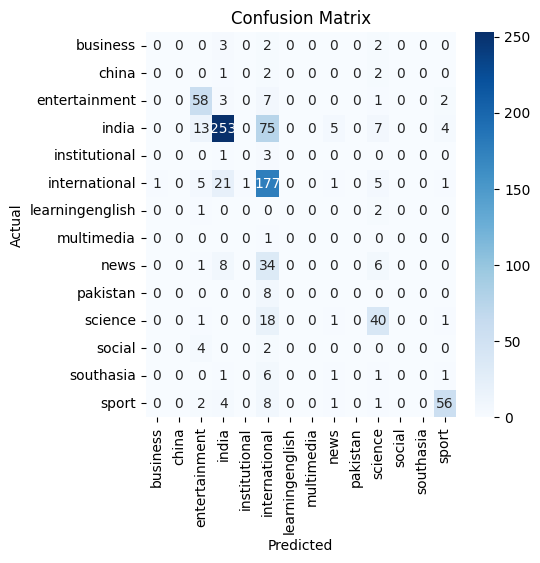

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = label_encoder.inverse_transform(y_pred)
true_classes = label_encoder.inverse_transform(y_true)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [31]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

       business       0.00      0.00      0.00         7
          china       0.00      0.00      0.00         5
  entertainment       0.68      0.82      0.74        71
          india       0.86      0.71      0.78       357
  institutional       0.00      0.00      0.00         4
  international       0.52      0.83      0.64       212
learningenglish       0.00      0.00      0.00         3
     multimedia       0.00      0.00      0.00         1
           news       0.00      0.00      0.00        49
       pakistan       0.00      0.00      0.00         8
        science       0.60      0.66      0.62        61
         social       0.00      0.00      0.00         6
      southasia       0.00      0.00      0.00        10
          sport       0.86      0.78      0.82        72

       accuracy                           0.67       866
      macro avg       0.25      0.27      0.26       866
   weighted avg       0.65   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# print(md5)

In [33]:
# print(classifier)